# Telco Customer Churn Prediction

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Ensemble Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb

# Non-Ensemble Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# To ignore warnings (use judiciously)
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = '/content/drive/MyDrive/4th_Semester/Machine_Learning/project/Telco_customer_churn.xlsx' # Adjust this path as needed
df_original = pd.read_excel(file_path)

print("Original data shape:", df_original.shape)
df_original.head()

Original data shape: (7043, 33)


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


## 2. Initial Data Exploration

In [3]:
print("\n--- Initial Data Info ---")
df_original.info()

print("\n--- Missing Values Before Processing ---")
print(df_original.isnull().sum())

print("\n--- Duplicates ---")
print(df_original.duplicated().sum())

print("\n--- Descriptive Statistics (All Columns) ---")
print(df_original.describe(include='all'))


--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 1

## 3. Data Preprocessing

In [4]:
df = df_original.copy() # Work on a copy to keep the original intact

# --- 3.1 Drop Initially Irrelevant Columns ---
columns_to_drop_initial = ['Count', 'Country', 'State', 'CustomerID', 'Lat Long', 'Latitude', 'Longitude']
df = df.drop(columns=columns_to_drop_initial)
print(f"Shape after dropping initial irrelevant columns: {df.shape}")

# --- 3.2 Handle Target Variable and Data Leakage Columns ---
df['Churn Label'] = df['Churn Label'].map({'No': 0, 'Yes': 1})

if 'Churn Value' in df.columns:
    df = df.drop(columns=['Churn Value'])
    print("Dropped 'Churn Value' column.")

if 'Churn Reason' in df.columns:
    df = df.drop(columns=['Churn Reason'])
    print("Dropped 'Churn Reason' column.")
print(f"Shape after handling target and leakage columns: {df.shape}")

# --- 3.3 Data Type Conversion and Handling High Cardinality Categoricals ---
if 'Total Charges' in df.columns:
    df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
    print(f"NaNs in 'Total Charges' after conversion: {df['Total Charges'].isnull().sum()}")

columns_to_drop_cardinality = []
if 'City' in df.columns:
    columns_to_drop_cardinality.append('City')
if 'Zip Code' in df.columns:
    columns_to_drop_cardinality.append('Zip Code')

if columns_to_drop_cardinality:
    df = df.drop(columns=columns_to_drop_cardinality)
    print(f"Dropped high-cardinality columns: {columns_to_drop_cardinality}")
print(f"Shape after data type conversion and dropping high-cardinality columns: {df.shape}")

# --- 3.4 Define Features (X) and Target (y) ---
if 'Churn Label' not in df.columns:
    raise ValueError("Target variable 'Churn Label' is missing from the DataFrame.")
X = df.drop(columns=['Churn Label'])
y = df['Churn Label']
print(f"Shape of features (X): {X.shape}, Shape of target (y): {y.shape}")

# --- 3.5 Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Shape of X_train: {X_train.shape}, X_test: {X_test.shape}")

# --- 3.6 Identify Numerical and Categorical Features ---
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

# --- 3.7 Preprocessing Pipeline (Imputation, Scaling, Encoding) ---
# Impute 'Total Charges'
if 'Total Charges' in numerical_features:
    median_total_charges = X_train['Total Charges'].median()
    X_train['Total Charges'] = X_train['Total Charges'].fillna(median_total_charges)
    X_test['Total Charges'] = X_test['Total Charges'].fillna(median_total_charges)
    print(f"NaNs in X_train['Total Charges'] after imputation: {X_train['Total Charges'].isnull().sum()}")

# Scale Numerical Features
scaler = StandardScaler()
X_train_scaled_np = scaler.fit_transform(X_train[numerical_features])
X_test_scaled_np = scaler.transform(X_test[numerical_features])
X_train_scaled_df = pd.DataFrame(X_train_scaled_np, columns=numerical_features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled_np, columns=numerical_features, index=X_test.index)

# One-Hot Encode Categorical Features
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_encoded_np = encoder.fit_transform(X_train[categorical_features])
X_test_encoded_np = encoder.transform(X_test[categorical_features])
encoded_col_names = encoder.get_feature_names_out(categorical_features)
X_train_encoded_df = pd.DataFrame(X_train_encoded_np, columns=encoded_col_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded_np, columns=encoded_col_names, index=X_test.index)

# Combine Processed Features
X_train_processed = pd.concat([X_train_scaled_df, X_train_encoded_df], axis=1)
X_test_processed = pd.concat([X_test_scaled_df, X_test_encoded_df], axis=1)

print(f"Shape of X_train_processed: {X_train_processed.shape}, X_test_processed: {X_test_processed.shape}")
print("Missing values in X_train_processed:", X_train_processed.isnull().sum().sum())
print("Missing values in X_test_processed:", X_test_processed.isnull().sum().sum())

Shape after dropping initial irrelevant columns: (7043, 26)
Dropped 'Churn Value' column.
Dropped 'Churn Reason' column.
Shape after handling target and leakage columns: (7043, 24)
NaNs in 'Total Charges' after conversion: 11
Dropped high-cardinality columns: ['City', 'Zip Code']
Shape after data type conversion and dropping high-cardinality columns: (7043, 22)
Shape of features (X): (7043, 21), Shape of target (y): (7043,)
Shape of X_train: (5634, 21), X_test: (1409, 21)
Numerical features: ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Score', 'CLTV']
Categorical features: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']
NaNs in X_train['Total Charges'] after imputation: 0
Shape of X_train_processed: (5634, 32), X_test_processed: (1409, 32)
Missing value

## 4. Model Training and Evaluation

### 4.1 Non-Ensemble Models

--- Starting Non-Ensemble Model Training and Evaluation ---

Training Logistic Regression...
Evaluating Logistic Regression...
--- Logistic Regression Results on Test Set ---
Accuracy: 0.9191
ROC AUC: 0.9746
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1035
           1       0.84      0.86      0.85       374

    accuracy                           0.92      1409
   macro avg       0.89      0.90      0.90      1409
weighted avg       0.92      0.92      0.92      1409



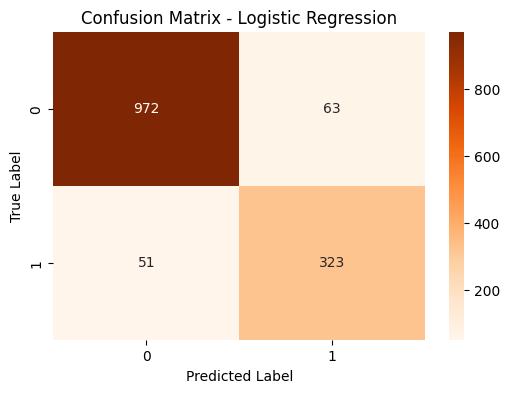

------------------------------------------

Training Support Vector Machine (Linear)...
Evaluating Support Vector Machine (Linear)...
--- Support Vector Machine (Linear) Results on Test Set ---
Accuracy: 0.9212
ROC AUC: 0.9737
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1035
           1       0.84      0.87      0.85       374

    accuracy                           0.92      1409
   macro avg       0.90      0.91      0.90      1409
weighted avg       0.92      0.92      0.92      1409



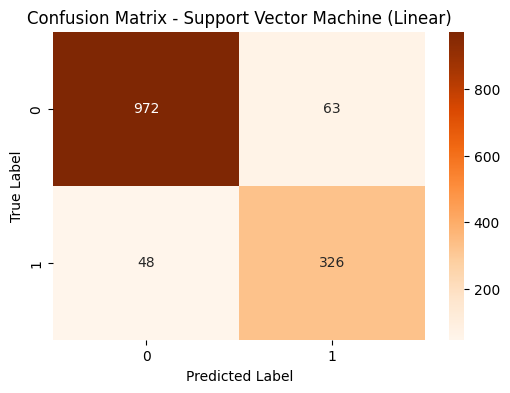

------------------------------------------

Training Support Vector Machine (RBF)...
Evaluating Support Vector Machine (RBF)...
--- Support Vector Machine (RBF) Results on Test Set ---
Accuracy: 0.9233
ROC AUC: 0.9721
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1035
           1       0.85      0.87      0.86       374

    accuracy                           0.92      1409
   macro avg       0.90      0.91      0.90      1409
weighted avg       0.92      0.92      0.92      1409



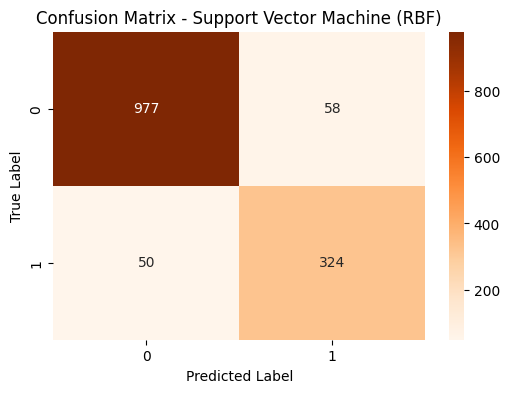

------------------------------------------

Training K-Nearest Neighbors...
Evaluating K-Nearest Neighbors...
--- K-Nearest Neighbors Results on Test Set ---
Accuracy: 0.9006
ROC AUC: 0.9447
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1035
           1       0.80      0.84      0.82       374

    accuracy                           0.90      1409
   macro avg       0.87      0.88      0.87      1409
weighted avg       0.90      0.90      0.90      1409



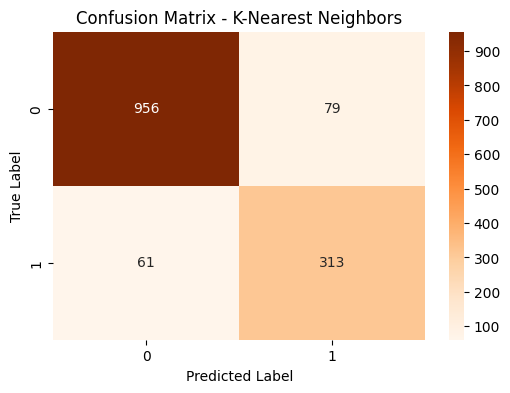

------------------------------------------

Training Decision Tree...
Evaluating Decision Tree...
--- Decision Tree Results on Test Set ---
Accuracy: 0.9106
ROC AUC: 0.8879
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1035
           1       0.83      0.84      0.83       374

    accuracy                           0.91      1409
   macro avg       0.88      0.89      0.89      1409
weighted avg       0.91      0.91      0.91      1409



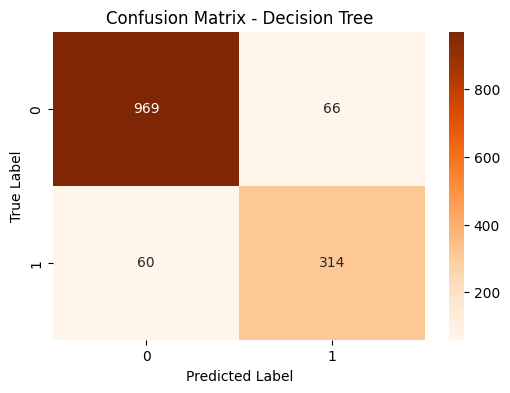

------------------------------------------

Training Gaussian Naive Bayes...
Evaluating Gaussian Naive Bayes...
--- Gaussian Naive Bayes Results on Test Set ---
Accuracy: 0.8112
ROC AUC: 0.8968
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      1035
           1       0.60      0.88      0.71       374

    accuracy                           0.81      1409
   macro avg       0.77      0.83      0.79      1409
weighted avg       0.85      0.81      0.82      1409



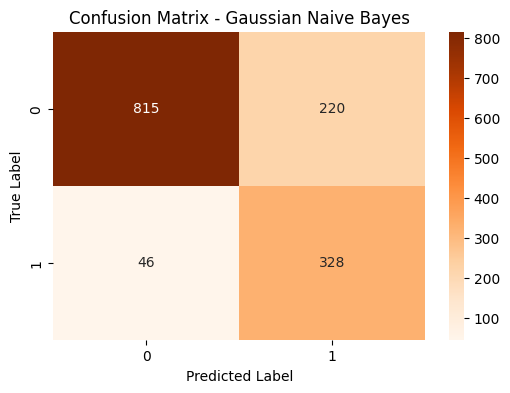

------------------------------------------


--- Non-Ensemble Model Performance Summary ---
                                 Accuracy  Precision (Churn)  Recall (Churn)  \
Support Vector Machine (RBF)     0.923350           0.848168        0.866310   
Support Vector Machine (Linear)  0.921221           0.838046        0.871658   
Logistic Regression              0.919092           0.836788        0.863636   
Decision Tree                    0.910575           0.826316        0.839572   
K-Nearest Neighbors              0.900639           0.798469        0.836898   
Gaussian Naive Bayes             0.811214           0.598540        0.877005   

                                 F1-score (Churn)   ROC AUC  
Support Vector Machine (RBF)             0.857143  0.972067  
Support Vector Machine (Linear)          0.854522  0.973739  
Logistic Regression                      0.850000  0.974618  
Decision Tree                            0.832891  0.887902  
K-Nearest Neighbors                  

In [5]:
non_ensemble_models_to_evaluate = {
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear', max_iter=1000),
    "Support Vector Machine (Linear)": SVC(kernel='linear', probability=True, random_state=42),
    "Support Vector Machine (RBF)": SVC(kernel='rbf', probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gaussian Naive Bayes": GaussianNB()
}

non_ensemble_results_summary = {}
print("--- Starting Non-Ensemble Model Training and Evaluation ---")

for model_name, model in non_ensemble_models_to_evaluate.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_processed, y_train)
    print(f"Evaluating {model_name}...")
    y_pred = model.predict(X_test_processed)

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = "N/A"

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    non_ensemble_results_summary[model_name] = {
        "Accuracy": accuracy,
        "Precision (Churn)": precision,
        "Recall (Churn)": recall,
        "F1-score (Churn)": f1,
        "ROC AUC": roc_auc
    }

    print(f"--- {model_name} Results on Test Set ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc if isinstance(roc_auc, str) else roc_auc:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print("------------------------------------------")

non_ensemble_results_df = pd.DataFrame.from_dict(non_ensemble_results_summary, orient='index')
non_ensemble_results_df = non_ensemble_results_df.sort_values(by="F1-score (Churn)", ascending=False)
print("\n\n--- Non-Ensemble Model Performance Summary ---")
print(non_ensemble_results_df)

### 4.2 Ensemble Models


--- Starting Ensemble Model Training and Evaluation ---

Training Random Forest...
Evaluating Random Forest...
--- Random Forest Results on Test Set ---
Accuracy: 0.9304
ROC AUC: 0.9720
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1035
           1       0.87      0.86      0.87       374

    accuracy                           0.93      1409
   macro avg       0.91      0.91      0.91      1409
weighted avg       0.93      0.93      0.93      1409



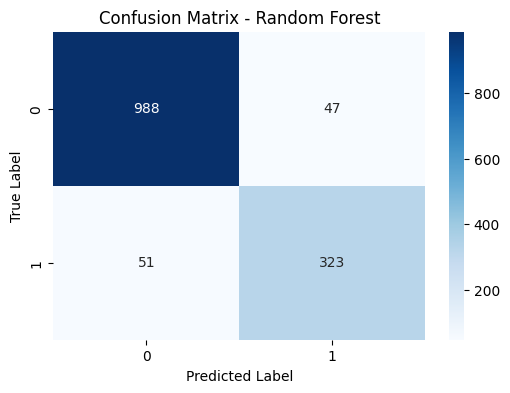

------------------------------------------

Training AdaBoost...
Evaluating AdaBoost...
--- AdaBoost Results on Test Set ---
Accuracy: 0.9191
ROC AUC: 0.9802
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1035
           1       0.84      0.85      0.85       374

    accuracy                           0.92      1409
   macro avg       0.90      0.90      0.90      1409
weighted avg       0.92      0.92      0.92      1409



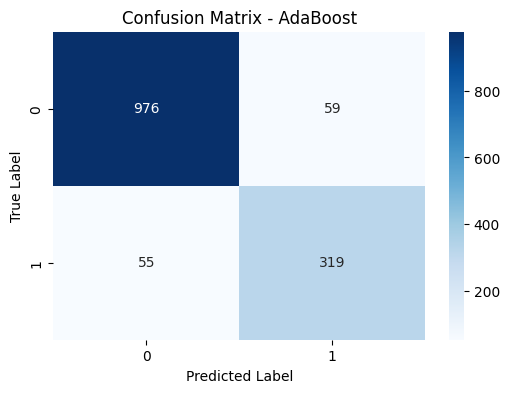

------------------------------------------

Training Gradient Boosting (Sklearn)...
Evaluating Gradient Boosting (Sklearn)...
--- Gradient Boosting (Sklearn) Results on Test Set ---
Accuracy: 0.9312
ROC AUC: 0.9827
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1035
           1       0.86      0.89      0.87       374

    accuracy                           0.93      1409
   macro avg       0.91      0.92      0.91      1409
weighted avg       0.93      0.93      0.93      1409



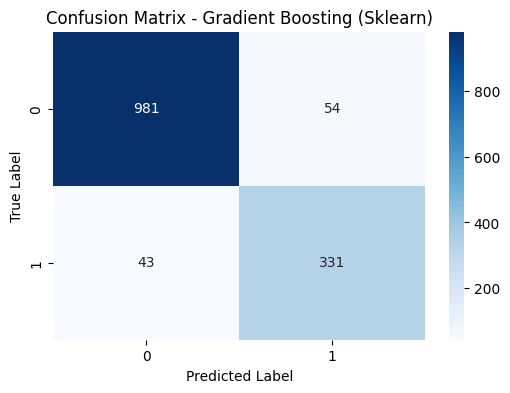

------------------------------------------

Training XGBoost...
Evaluating XGBoost...
--- XGBoost Results on Test Set ---
Accuracy: 0.9290
ROC AUC: 0.9810
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1035
           1       0.87      0.86      0.87       374

    accuracy                           0.93      1409
   macro avg       0.91      0.91      0.91      1409
weighted avg       0.93      0.93      0.93      1409



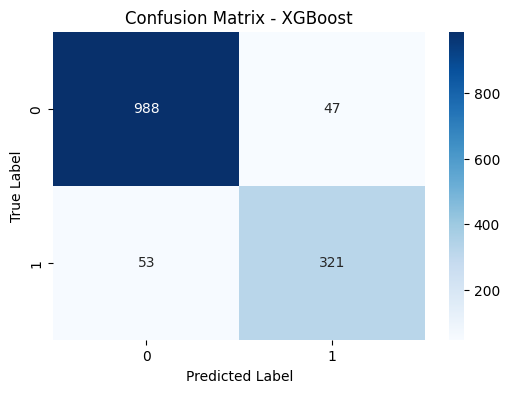

------------------------------------------

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 977
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
Evaluating LightGBM...
--- LightGBM Results on Test Set ---
Accuracy: 0.9333
ROC AUC: 0.9820
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1035
           1       0.86      0.89      0.88       374

    accuracy                           0.93 

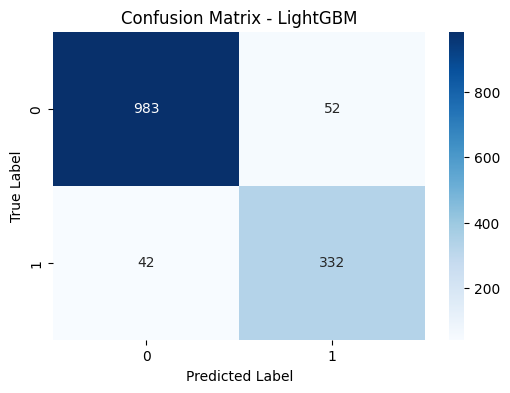

------------------------------------------


--- Ensemble Model Performance Summary ---
                             Accuracy  Precision (Churn)  Recall (Churn)  \
LightGBM                     0.933286           0.864583        0.887701   
Gradient Boosting (Sklearn)  0.931157           0.859740        0.885027   
Random Forest                0.930447           0.872973        0.863636   
XGBoost                      0.929028           0.872283        0.858289   
AdaBoost                     0.919092           0.843915        0.852941   

                             F1-score (Churn)   ROC AUC  
LightGBM                             0.875989  0.981999  
Gradient Boosting (Sklearn)          0.872200  0.982740  
Random Forest                        0.868280  0.971986  
XGBoost                              0.865229  0.980979  
AdaBoost                             0.848404  0.980238  


In [6]:
ensemble_models_to_evaluate = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting (Sklearn)": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

ensemble_results_summary = {}
print("\n--- Starting Ensemble Model Training and Evaluation ---")

for model_name, model in ensemble_models_to_evaluate.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_processed, y_train)
    print(f"Evaluating {model_name}...")
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    ensemble_results_summary[model_name] = {
        "Accuracy": accuracy,
        "Precision (Churn)": precision,
        "Recall (Churn)": recall,
        "F1-score (Churn)": f1,
        "ROC AUC": roc_auc
    }

    print(f"--- {model_name} Results on Test Set ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print("------------------------------------------")

ensemble_results_df = pd.DataFrame.from_dict(ensemble_results_summary, orient='index')
ensemble_results_df = ensemble_results_df.sort_values(by="F1-score (Churn)", ascending=False)
print("\n\n--- Ensemble Model Performance Summary ---")
print(ensemble_results_df)

## 5. Results Comparison and Visualization


--- Non-Ensemble Model Performance Summary ---
                                 Accuracy  Precision (Churn)  Recall (Churn)  \
Support Vector Machine (RBF)     0.923350           0.848168        0.866310   
Support Vector Machine (Linear)  0.921221           0.838046        0.871658   
Logistic Regression              0.919092           0.836788        0.863636   
Decision Tree                    0.910575           0.826316        0.839572   
K-Nearest Neighbors              0.900639           0.798469        0.836898   
Gaussian Naive Bayes             0.811214           0.598540        0.877005   

                                 F1-score (Churn)   ROC AUC  
Support Vector Machine (RBF)             0.857143  0.972067  
Support Vector Machine (Linear)          0.854522  0.973739  
Logistic Regression                      0.850000  0.974618  
Decision Tree                            0.832891  0.887902  
K-Nearest Neighbors                      0.817232  0.944668  
Gaussian Naive Baye

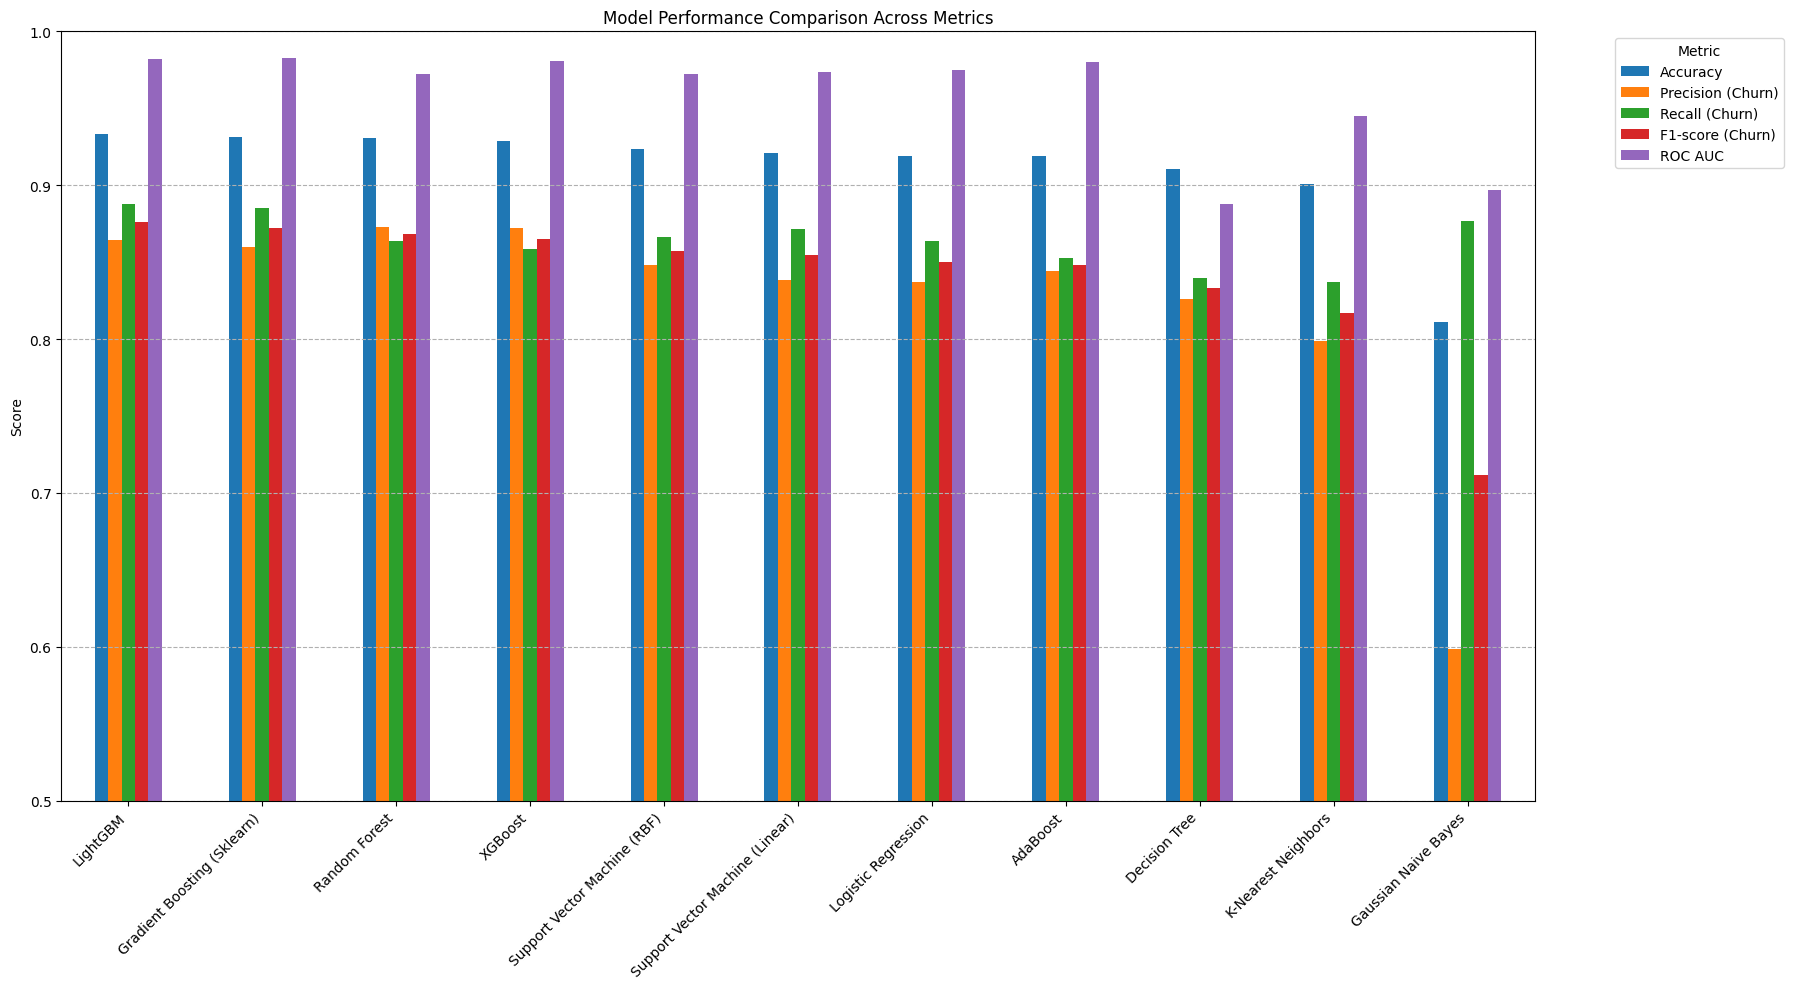

In [7]:
print("\n--- Non-Ensemble Model Performance Summary ---")
print(non_ensemble_results_df)

print("\n--- Ensemble Model Performance Summary ---")
print(ensemble_results_df)

combined_results_df = pd.concat([non_ensemble_results_df, ensemble_results_df])
combined_results_df = combined_results_df.sort_values(by="F1-score (Churn)", ascending=False)
print("\n\n--- Combined Model Performance Summary (Sorted by F1-score for Churn) ---")
print(combined_results_df)

# --- Visualizing Model Performance ---
print("\n--- Visualizing All Model Performance (Sorted by F1-score Churn) ---")
combined_results_df.plot(kind='bar', figsize=(18, 10))
plt.title('Model Performance Comparison Across Metrics')
plt.ylabel('Score')
plt.ylim(0.5, 1.0) # Adjust y-axis for better visualization of top performers
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

## 6. Cross-Validation and Hyperparameter Tuning (Example for Top Model)



--- Cross-Validation for Top Performing Model (e.g., LightGBM) ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1196, number of negative: 3311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 977
[LightGBM] [Info] Number of data points in the train set: 4507, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265365 -> initscore=-1.018268
[LightGBM] [Info] Start training from score -1.018268
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1196, number of negative: 3311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove 

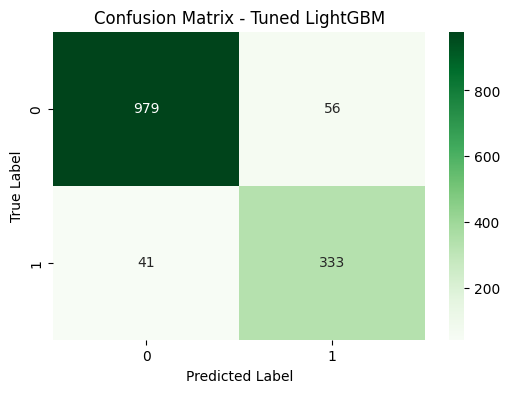

In [8]:
print("\n\n--- Cross-Validation for Top Performing Model (e.g., LightGBM) ---")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lgbm_for_cv = lgb.LGBMClassifier(random_state=42) # Use default for CV before tuning

cv_accuracy_scores = cross_val_score(lgbm_for_cv, X_train_processed, y_train, cv=skf, scoring='accuracy')
cv_f1_scores = cross_val_score(lgbm_for_cv, X_train_processed, y_train, cv=skf, scoring='f1')
cv_roc_auc_scores = cross_val_score(lgbm_for_cv, X_train_processed, y_train, cv=skf, scoring='roc_auc')

print(f"LightGBM Cross-Validated Accuracy: {cv_accuracy_scores.mean():.4f} (+/- {cv_accuracy_scores.std():.4f})")
print(f"LightGBM Cross-Validated F1 scores: {cv_f1_scores.mean():.4f} (+/- {cv_f1_scores.std():.4f})")
print(f"LightGBM Cross-Validated ROC AUC: {cv_roc_auc_scores.mean():.4f} (+/- {cv_roc_auc_scores.std():.4f})")

print("\n\n--- Hyperparameter Tuning for LightGBM (Example using RandomizedSearchCV) ---")
lgbm_model_tuned = lgb.LGBMClassifier(random_state=42)

param_dist_lgbm = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# RandomizedSearchCV is often faster for larger search spaces
random_search_lgbm = RandomizedSearchCV(estimator=lgbm_model_tuned,
                                          param_distributions=param_dist_lgbm,
                                          n_iter=50, # Number of parameter settings that are sampled
                                          cv=skf,
                                          scoring='f1', # Focus on F1 for churn class
                                          verbose=1,
                                          random_state=42,
                                          n_jobs=-1)

random_search_lgbm.fit(X_train_processed, y_train)

best_lgbm_model = random_search_lgbm.best_estimator_
print(f"\nBest Parameters for LightGBM (RandomizedSearch): {random_search_lgbm.best_params_}")
print(f"Best F1 Score (RandomizedSearch CV): {random_search_lgbm.best_score_:.4f}")

# --- 7. Final Evaluation of the Tuned Best Model ---
print("\n\n--- Final Evaluation of Tuned LightGBM on Test Set ---")
y_pred_final_lgbm = best_lgbm_model.predict(X_test_processed)
y_pred_proba_final_lgbm = best_lgbm_model.predict_proba(X_test_processed)[:, 1]

print(f"Tuned LightGBM - Test Set Accuracy: {accuracy_score(y_test, y_pred_final_lgbm):.4f}")
print(f"Tuned LightGBM - Test Set ROC AUC: {roc_auc_score(y_test, y_pred_proba_final_lgbm):.4f}")
print("\nClassification Report (Tuned LightGBM):")
print(classification_report(y_test, y_pred_final_lgbm, zero_division=0))
cm_final_lgbm = confusion_matrix(y_test, y_pred_final_lgbm)
plt.figure(figsize=(6,4))
sns.heatmap(cm_final_lgbm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Tuned LightGBM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 8. Feature Importance (for the best model)



--- Feature Importances from Tuned LightGBM ---
                            feature  importance
1                   Monthly Charges        2451
0                     Tenure Months        2160
4                              CLTV        1913
2                     Total Charges        1701
3                       Churn Score        1612
8                    Dependents_Yes         622
30  Payment Method_Electronic check         530
28            Paperless Billing_Yes         456
12     Internet Service_Fiber optic         435
27                Contract_Two year         375
26                Contract_One year         328
7                       Partner_Yes         253
17                Online Backup_Yes         248
5                       Gender_Male         244
11               Multiple Lines_Yes         196


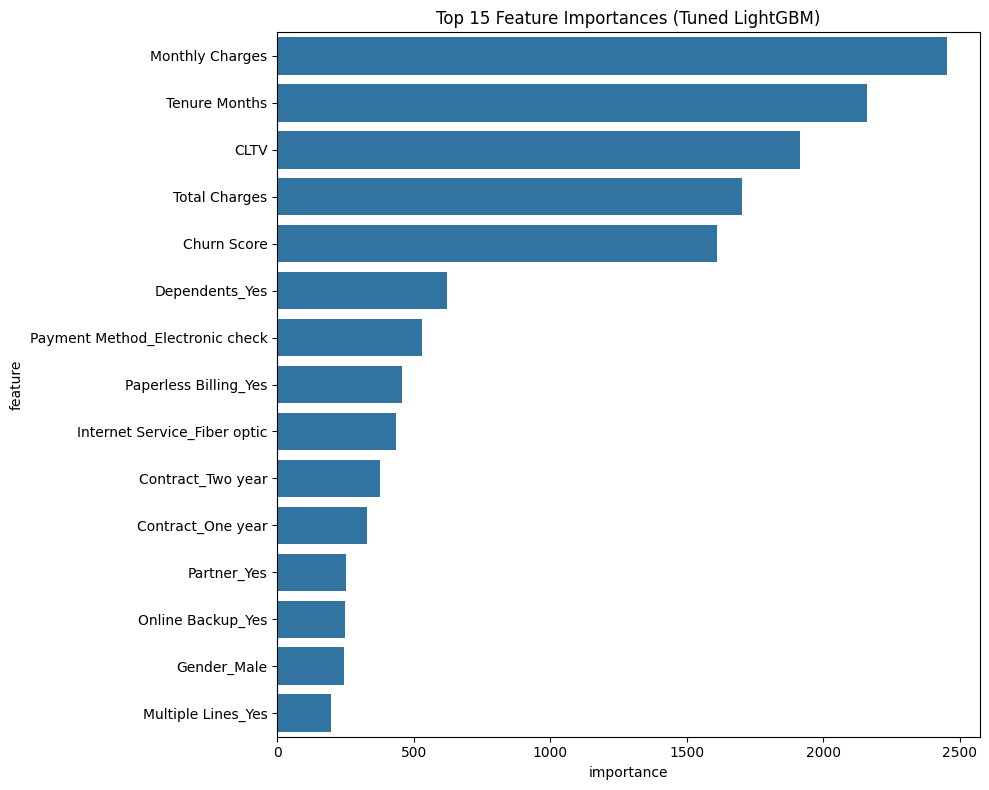

In [9]:
if hasattr(best_lgbm_model, 'feature_importances_'):
    importances = best_lgbm_model.feature_importances_
    feature_names = X_train_processed.columns

    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    print("\n\n--- Feature Importances from Tuned LightGBM ---")
    print(feature_importance_df.head(15))

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
    plt.title('Top 15 Feature Importances (Tuned LightGBM)')
    plt.tight_layout()
    plt.show()
else:
    print("The best model does not have feature_importances_ attribute (e.g., it might be an SVM).")

## 9. Conclusion

In [10]:
# Based on the analysis, summarize the findings.
# Example:
print("\n--- Conclusion ---")
print(f"The best performing model after initial evaluation and example tuning is: {random_search_lgbm.best_estimator_.__class__.__name__}")
print(f"Achieved an F1-score (Churn) of {f1_score(y_test, y_pred_final_lgbm):.4f} on the test set.")
print(f"Key features influencing churn include: {feature_importance_df['feature'].iloc[0]}, {feature_importance_df['feature'].iloc[1]}, and {feature_importance_df['feature'].iloc[2]}.")
print("Further steps could include more extensive hyperparameter tuning for other top models, exploring different feature engineering techniques, or addressing class imbalance more deeply if needed.")


--- Conclusion ---
The best performing model after initial evaluation and example tuning is: LGBMClassifier
Achieved an F1-score (Churn) of 0.8729 on the test set.
Key features influencing churn include: Monthly Charges, Tenure Months, and CLTV.
Further steps could include more extensive hyperparameter tuning for other top models, exploring different feature engineering techniques, or addressing class imbalance more deeply if needed.


# Model Export

In [11]:
# Assume the following variables are already defined from your previous notebook cells:
# X_train_processed, y_train, X_test_processed, y_test
# best_lgbm_model (your tuned LightGBM model from RandomizedSearchCV)
# scaler (the StandardScaler fitted on X_train[numerical_features])
# encoder (the OneHotEncoder fitted on X_train[categorical_features])
# median_total_charges (the median of 'Total Charges' from X_train)
# numerical_features (list of numerical column names before processing)
# categorical_features (list of categorical column names before processing)
# X_train_processed_columns = X_train_processed.columns.tolist() # The final column order

# If any of these are not explicitly defined, make sure to define them based on your notebook.
# For example, if best_lgbm_model was from random_search_lgbm:
# best_lgbm_model = random_search_lgbm.best_estimator_
# And X_train_processed_columns = X_train_processed.columns.tolist()


# --- 6. (Continued) Saving the Model and Preprocessing Components ---
import joblib
import os

# Define a directory in your Colab environment to save the files
# (or mount Google Drive again if you want to save them there persistently)
save_dir = "churn_model_artifacts"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model_filename = os.path.join(save_dir, 'final_churn_model.joblib')
scaler_filename = os.path.join(save_dir, 'scaler.joblib')
encoder_filename = os.path.join(save_dir, 'encoder.joblib')
median_charges_filename = os.path.join(save_dir, 'median_total_charges.joblib')
feature_info_filename = os.path.join(save_dir, 'feature_info.joblib')

# Save the components
joblib.dump(best_lgbm_model, model_filename)
joblib.dump(scaler, scaler_filename)
joblib.dump(encoder, encoder_filename)
joblib.dump(median_total_charges, median_charges_filename)

# Store feature names and processed column order
# Ensure numerical_features and categorical_features are from the X_train BEFORE processing
# Ensure X_train_processed_columns is the list of columns AFTER all preprocessing on X_train
feature_info = {
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'processed_column_names': X_train_processed.columns.tolist()
}
joblib.dump(feature_info, feature_info_filename)

print(f"Model and preprocessing components saved in directory: {save_dir}")
print(f"  Model: {model_filename}")
print(f"  Scaler: {scaler_filename}")
print(f"  Encoder: {encoder_filename}")
print(f"  Median Total Charges: {median_charges_filename}")
print(f"  Feature Info: {feature_info_filename}")

# To download these files from Colab to your local machine:
# from google.colab import files
# files.download(model_filename)
# files.download(scaler_filename)
# files.download(encoder_filename)
# files.download(median_charges_filename)
# files.download(feature_info_filename)

Model and preprocessing components saved in directory: churn_model_artifacts
  Model: churn_model_artifacts/final_churn_model.joblib
  Scaler: churn_model_artifacts/scaler.joblib
  Encoder: churn_model_artifacts/encoder.joblib
  Median Total Charges: churn_model_artifacts/median_total_charges.joblib
  Feature Info: churn_model_artifacts/feature_info.joblib


#Prediction Function and Example Usage (in Colab)

In [12]:
# --- 7. Prediction Function and Example Usage (in Colab) ---

# We need to load these again as if we are in a new session/script
loaded_model = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename)
loaded_encoder = joblib.load(encoder_filename)
loaded_median_charges = joblib.load(median_charges_filename)
loaded_feature_info = joblib.load(feature_info_filename)

# Extract information from loaded_feature_info
numerical_features_loaded = loaded_feature_info['numerical_features']
categorical_features_loaded = loaded_feature_info['categorical_features']
processed_column_names_loaded = loaded_feature_info['processed_column_names']


def preprocess_new_data_colab(new_data_df, scaler_obj, encoder_obj, median_charges_val, num_feats, cat_feats, proc_col_names):
    """
    Preprocesses new customer data in the same way as the training data.
    'new_data_df' should be a pandas DataFrame with the same initial columns as X_train (before processing).
    """
    # --- Handle 'Total Charges' (convert to numeric, impute NaNs) ---
    if 'Total Charges' in new_data_df.columns:
        new_data_df['Total Charges'] = pd.to_numeric(new_data_df['Total Charges'], errors='coerce')
        # Impute only if NaNs were actually produced or if the column was missing
        if new_data_df['Total Charges'].isnull().any():
            new_data_df['Total Charges'] = new_data_df['Total Charges'].fillna(median_charges_val)
    # If 'Total Charges' column is missing entirely but was a numerical feature:
    elif 'Total Charges' in num_feats and 'Total Charges' not in new_data_df.columns:
        print("Warning: 'Total Charges' column missing. Imputing with training median.")
        new_data_df['Total Charges'] = median_charges_val # Create and fill

    # --- Ensure all expected numerical features are present, fill with median/0 if not ---
    for feature in num_feats:
        if feature not in new_data_df.columns:
            if feature == 'Total Charges': # Already handled above if present
                pass
            else:
                # For other numerical features, you might need a more robust default
                # or raise an error if they are critical and missing.
                # For this example, filling with 0.
                print(f"Warning: Numerical feature '{feature}' was not provided. Using 0 as default.")
                new_data_df[feature] = 0

    # --- Ensure all expected categorical features are present, fill with a placeholder like 'Missing' if not ---
    for feature in cat_feats:
        if feature not in new_data_df.columns:
            # Using 'Unknown' or a common category might be better if the encoder can handle it
            # or if you have a specific imputation strategy for unseen categoricals.
            # If encoder's handle_unknown='ignore', this step for missing *columns* is critical.
            # The encoder handles unknown *values* within existing columns.
            print(f"Warning: Categorical feature '{feature}' was not provided. Using 'Unknown' as default.")
            new_data_df[feature] = 'Unknown'


    # --- Separate numerical and categorical for scaling/encoding ---
    # Ensure we only select features that are actually in the new_data_df at this point
    current_numerical_features = [f for f in num_feats if f in new_data_df.columns]
    current_categorical_features = [f for f in cat_feats if f in new_data_df.columns]

    new_numerical_df = new_data_df[current_numerical_features]
    new_categorical_df = new_data_df[current_categorical_features]

    # --- Scale numerical features ---
    new_scaled_np = scaler_obj.transform(new_numerical_df)
    new_scaled_df = pd.DataFrame(new_scaled_np, columns=current_numerical_features, index=new_data_df.index)

    # --- One-Hot Encode categorical features ---
    new_encoded_np = encoder_obj.transform(new_categorical_df)
    encoded_col_names_from_loader = encoder_obj.get_feature_names_out(current_categorical_features)
    new_encoded_df = pd.DataFrame(new_encoded_np, columns=encoded_col_names_from_loader, index=new_data_df.index)

    # --- Combine processed features ---
    new_data_processed = pd.concat([new_scaled_df, new_encoded_df], axis=1)

    # --- Ensure columns are in the same order and all expected columns are present ---
    # Fill missing columns (that were in training but not in this new data after OHE) with 0
    new_data_processed = new_data_processed.reindex(columns=proc_col_names, fill_value=0)

    return new_data_processed

def predict_churn_colab(customer_data_dict):
    """
    Takes a dictionary of customer data, preprocesses it, and returns a churn prediction.
    """
    # Convert dictionary to DataFrame
    # The keys in customer_data_dict should match the original raw feature names
    df_input = pd.DataFrame([customer_data_dict])

    # Preprocess the data
    df_processed = preprocess_new_data_colab(df_input,
                                             loaded_scaler,
                                             loaded_encoder,
                                             loaded_median_charges,
                                             numerical_features_loaded,
                                             categorical_features_loaded,
                                             processed_column_names_loaded)

    # Make prediction
    prediction_val = loaded_model.predict(df_processed)
    probability_val = loaded_model.predict_proba(df_processed)[:, 1] # Probability of churn

    return {"prediction_label": "Churn" if prediction_val[0] == 1 else "No Churn",
            "prediction_numeric": prediction_val[0],
            "churn_probability_value": probability_val[0],
            "churn_probability_formatted": f"{probability_val[0]:.2%}"}

# --- Example usage of the prediction function in Colab ---

# Define a new customer's data as a dictionary.
# The keys MUST match the column names of your original DataFrame 'X'
# (before any preprocessing like scaling or one-hot encoding was applied to X_train).
# The values should be in the raw format (e.g., strings for categories).

# To get the list of original columns in the correct order (from X before preprocessing):
# If you still have 'X' from your preprocessing steps:
# original_X_columns = X.columns.tolist()
# print("Original X columns:", original_X_columns)
# Ensure the dictionary keys below match these names and their expected data types.

# Example: Let's assume these were the original columns X had:
# ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
#  'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security',
#  'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
#  'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
#  'Monthly Charges', 'Total Charges', 'Churn Score', 'CLTV']
# 'Senior Citizen' was an object ('Yes'/'No')

new_customer_example_1 = {
    'Gender': 'Female',
    'Senior Citizen': 'No', # Was object type, so 'No' or 'Yes'
    'Partner': 'Yes',
    'Dependents': 'No',
    'Tenure Months': 1, # Low tenure
    'Phone Service': 'Yes',
    'Multiple Lines': 'No',
    'Internet Service': 'DSL',
    'Online Security': 'No',
    'Online Backup': 'No',
    'Device Protection': 'No',
    'Tech Support': 'No',
    'Streaming TV': 'No',
    'Streaming Movies': 'No',
    'Contract': 'Month-to-month', # Often associated with churn
    'Paperless Billing': 'Yes',
    'Payment Method': 'Electronic check',
    'Monthly Charges': 25.0, # Low monthly charges
    'Total Charges': '25.0',  # String, will be converted to numeric
    'Churn Score': 90,    # High churn score
    'CLTV': 2500          # Example CLTV
}

new_customer_example_2 = {
    'Gender': 'Male',
    'Senior Citizen': 'No',
    'Partner': 'Yes',
    'Dependents': 'Yes',
    'Tenure Months': 70, # High tenure
    'Phone Service': 'Yes',
    'Multiple Lines': 'Yes',
    'Internet Service': 'Fiber optic',
    'Online Security': 'Yes',
    'Online Backup': 'Yes',
    'Device Protection': 'Yes',
    'Tech Support': 'Yes',
    'Streaming TV': 'Yes',
    'Streaming Movies': 'Yes',
    'Contract': 'Two year', # Often associated with retention
    'Paperless Billing': 'Yes',
    'Payment Method': 'Credit card (automatic)',
    'Monthly Charges': 110.5,
    'Total Charges': '7700.0',
    'Churn Score': 20,     # Low churn score
    'CLTV': 5500
}

print("\n--- Predicting for New Customer Example 1 (Likely Churn) ---")
result1 = predict_churn_colab(new_customer_example_1)
print(f"  Prediction: {result1['prediction_label']}")
print(f"  Probability of Churn: {result1['churn_probability_formatted']}")

print("\n--- Predicting for New Customer Example 2 (Likely No Churn) ---")
result2 = predict_churn_colab(new_customer_example_2)
print(f"  Prediction: {result2['prediction_label']}")
print(f"  Probability of Churn: {result2['churn_probability_formatted']}")

# Example of how to handle input that might be missing some columns
# (though for a UI, you'd ideally ensure all required fields are entered)
new_customer_example_missing_cols = {
    'Gender': 'Male',
    'Senior Citizen': 'Yes',
    'Partner': 'No',
    'Dependents': 'No',
    'Tenure Months': 5,
    'Phone Service': 'No', # 'Multiple Lines' might be dependent on this, ensure encoder handles it
    # 'Multiple Lines': 'No phone service', # Let's assume this column is missing
    'Internet Service': 'Fiber optic',
    # 'Online Security': 'No', # Missing
    'Online Backup': 'Yes',
    'Device Protection': 'No',
    'Tech Support': 'No',
    'Streaming TV': 'Yes',
    'Streaming Movies': 'Yes',
    'Contract': 'Month-to-month',
    'Paperless Billing': 'No',
    'Payment Method': 'Mailed check',
    'Monthly Charges': 90.0,
    # 'Total Charges': '450.0', # Missing
    'Churn Score': 70,
    'CLTV': 3000
}
print("\n--- Predicting for New Customer Example with Missing Columns ---")
try:
    result_missing = predict_churn_colab(new_customer_example_missing_cols)
    print(f"  Prediction: {result_missing['prediction_label']}")
    print(f"  Probability of Churn: {result_missing['churn_probability_formatted']}")
except Exception as e:
    print(f"  Error during prediction for customer with missing columns: {e}")


--- Predicting for New Customer Example 1 (Likely Churn) ---
  Prediction: Churn
  Probability of Churn: 95.52%

--- Predicting for New Customer Example 2 (Likely No Churn) ---
  Prediction: No Churn
  Probability of Churn: 1.38%

--- Predicting for New Customer Example with Missing Columns ---
  Prediction: Churn
  Probability of Churn: 61.22%
